### ドロップアウト
ドロップアウトというテクニックを使って、過学習を抑制します。  

### 過学習の発生
前回のコードで、エボック数を100から200に増やします。

Epoch:0/200 Error_train:1.1145295098207528 Error_test:1.1169584375025552
Epoch:20/200 Error_train:0.25907074382474266 Error_test:0.2639276386399533
Epoch:40/200 Error_train:0.07624658452516328 Error_test:0.10045242396656762
Epoch:60/200 Error_train:0.04862543345561953 Error_test:0.06808758334853679
Epoch:80/200 Error_train:0.030145214211071098 Error_test:0.06779887705328921
Epoch:100/200 Error_train:0.022797339959321043 Error_test:0.06869666644321983
Epoch:120/200 Error_train:0.017425972579040543 Error_test:0.0659940282541272
Epoch:140/200 Error_train:0.015002125727499345 Error_test:0.07134966405022816
Epoch:160/200 Error_train:0.009891598974488342 Error_test:0.07254305081538603


findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


Epoch:180/200 Error_train:0.007774911905666434 Error_test:0.07825360797843965


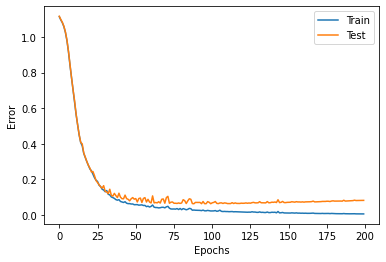

Accuracy Train: 100.0% Accuracy Test: 94.66666666666667%


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- Irisデータの読み込み --
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct) # サンプル数

# -- 入力データを標準化する　--
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data -ave_input) / std_input

# -- 正解をone-hot表現にする --
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0
    
# -- 訓練データとテストデータ
index = np.arange(n_data)
# こんな分け方でいいんだ
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

# これで分けられるのすごい
input_train = input_data[index_train, :] # 訓練　入力
correct_train = correct_data[index_train, :] # 訓練　正解
input_test = input_data[index_test, :] # テスト　入力
correct_test = correct_data[index_test, :] # テスト　正解

n_train = input_train.shape[0] # 訓練データのサンプル数
n_test = input_test.shape[0] # テストデータのサンプル数

# -- 各設定値 --
n_in = 4 # 入力層のニューロン数
n_mid = 25 # 中間層のニューロン数
n_out = 3 # 出力層のニューロン数

wb_width = 0.1 # 重みとバイアスの広がり具合
eta = 0.01 # 学習係数
epoch = 200
batch_size = 8
interval = 20 # 経過の表示間隔

# -- 各層の継承元 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n) # 重み（行列）
        self.b = wb_width * np.random.randn(n) # バイアス（ベクトル）
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 中間層 --
class MiddleLayer(BaseLayer):
    # 順伝播
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
        
    # 逆伝播
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1) # ReLU
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 出力層 -- 
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        # ソフトマックス関数
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 各層の初期化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 順伝播 --
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)
    
# -- 逆伝播　--
def back_propagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)
    
# -- 重みとバイアスの更新 --
def update_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)
    
# -- 誤差を計算 --
def get_error(t, batch_size):
    # 交差エントロピー
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

# --　誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size # 1エポックあたりのバッチ数

for i in range(epoch):
    
    # -- 誤差の計測 --
    forward_propagation(input_train)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test)
    error_test = get_error(correct_test, n_test)
    
    # -- 誤差の記録 --
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    # -- 経過の表示 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
                  "Error_train:" + str(error_train),
                   "Error_test:" + str(error_test))
        
    # -- 学習 --
    index_random = np.arange(n_train)
    np.random.shuffle(index_random) # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 順伝播と逆伝播
        forward_propagation(x)
        back_propagation(t)
        
        # 重みとバイアスの更新
        update_wb()
        
# -- 誤差の記録をグラフ表示 --
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 --
forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
          "Accuracy Test:", str(count_test/n_test*100) + "%")

### ドロップアウトの実装
今回は、過学習対策としてドロップアウトを実装します。  
ドロップアウトとは、ニューラルネットワークのニューロンをランダムに無効にすることにより、汎化性能を向上させるテクニックです。  
ドロップアウトの概念を以下の図に示します。  

<img src="../images/dropout.png">

あえて情報をを欠落させて厳しい条件でニューラルネットワークを育成することにより、より頑健な学習が行われます。  

ドロップアウトは、中間層や出力層のように層として実装するとコード上扱いやすくなります。  
今回は、以下の図のようにドロップアウト層を配置します。

<img src="../images/dropout_layer.png">

2つの中間層の下に、それぞれドロップアウト層を1つずつ配置します。  
コードは以下

In [ ]:
# -- ドロップアウト --
class Dropout:
    def __init__(self, dropout_ratio):
        # ニューロンを無効にする確率
        seld.dropout_ratio = dropout_ratio
        
    def forward(self, x, is_train):
        # is_train : 学習時はTrue
        if is_train:
            # 入力と同じ形状の乱数の行列
            if is_train:
                # 入力と同じ形状の乱数の行列
                rand = np.random.rand(*x.shape)
                self.dropout = np.where(rand > self.dropout_ratio, 1, 0) # 1:有効　0:無効
                self.y = x * self.dropout # ニューロンをランダムに無効化
            else:
                # テスト時は出力を下げる
                self.y = (1-self.dropout_ratio)*x
                
    def bacward(self, grad_y):
        self.grad_x = grad_y * self.dropout # 無効なニューロンでは逆伝播しない

`__init__`メソッドは引数でニューロンを無効にする確率`dropout_ratio`を受け取ります。  

順伝播用の`forward`メソッドでは、学習時とテスト時で処理を分けます。  
学習時は入力と同じ形状の乱数の行列を作り、この乱数と`self.dropout_ratio`を比較して対応するニューロンを有効にするか無効にするかを決めます。  
有効は1、無効は0に設定しますが、これを`self.dropout`に格納しておきます。  

そして、この行列と入力の要素積をとると、出力を表す行列`self.y`の要素はランダムに0になります。  
これは、上の層のニューロンがランダムに無効化されることを意味します。  

テスト時は、入力に`(1-self.dropout_ratio)`をかけることによって出力を下げます。  
これにより、学習時と同等の出力が得られるようになります。(??? 分かってない、そうなん？)  

逆伝播用の`backward`メソッドでは、`grad_y`に`self.dropout`をかけることによって無効なニューロンでは逆伝播しないようにします。

In [ ]:
# -- 各層の初期化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

# -- 順伝播 --
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)
    
# --逆伝播 --
def backpropagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)

### ドロップアウトの導入
上記のコードにドロップアウトを導入します。

Epoch:0/200 Error_train:1.1100694128776714 Error_test:1.1102563974340247
Epoch:20/200 Error_train:1.0233072681236959 Error_test:1.0275307083812455
Epoch:40/200 Error_train:0.48643514070704563 Error_test:0.49341959624811316
Epoch:60/200 Error_train:0.36375300724229714 Error_test:0.36231690231713626
Epoch:80/200 Error_train:0.2735100592592415 Error_test:0.26924460572033565
Epoch:100/200 Error_train:0.20331488985840665 Error_test:0.20070799483176335
Epoch:120/200 Error_train:0.14922580553358022 Error_test:0.14830440201654763
Epoch:140/200 Error_train:0.11135073315071636 Error_test:0.13219842628328393
Epoch:160/200 Error_train:0.09489789618275245 Error_test:0.10252140403210178
Epoch:180/200 Error_train:0.08126528127983072 Error_test:0.09205024117933223


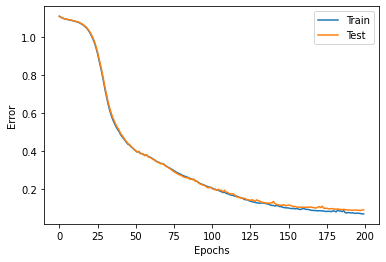

Accuracy Train: 98.66666666666667% Accuracy Test: 96.0%


In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- Irisデータの読み込み --
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct) # サンプル数

# -- 入力データを標準化する　--
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data -ave_input) / std_input

# -- 正解をone-hot表現にする --
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0
    
# -- 訓練データとテストデータ
index = np.arange(n_data)
# こんな分け方でいいんだ
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

# これで分けられるのすごい
input_train = input_data[index_train, :] # 訓練　入力
correct_train = correct_data[index_train, :] # 訓練　正解
input_test = input_data[index_test, :] # テスト　入力
correct_test = correct_data[index_test, :] # テスト　正解

n_train = input_train.shape[0] # 訓練データのサンプル数
n_test = input_test.shape[0] # テストデータのサンプル数

# -- 各設定値 --
n_in = 4 # 入力層のニューロン数
n_mid = 25 # 中間層のニューロン数
n_out = 3 # 出力層のニューロン数

wb_width = 0.1 # 重みとバイアスの広がり具合
eta = 0.01 # 学習係数
epoch = 200
batch_size = 8
interval = 20 # 経過の表示間隔

# -- 各層の継承元 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n) # 重み（行列）
        self.b = wb_width * np.random.randn(n) # バイアス（ベクトル）
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 中間層 --
class MiddleLayer(BaseLayer):
    # 順伝播
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
        
    # 逆伝播
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1) # ReLU
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 出力層 -- 
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        # ソフトマックス関数
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio # ニューロンを無効にする確率
        
    def forward(self, x, is_train): # is_train: 学習時はTrue
        if is_train:
            rand = np.random.rand(*x.shape) # 入力と同じ形状の乱数の行列
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0) # 1:有効　0:無効
            
            self.y = x * self.dropout # ニューロンをランダムに無効化
        else:
            self.y = (1-self.dropout_ratio)*x # テスト時は出力を下げる
            
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout # 無効なニューロンでは逆伝播しない
        
        
# -- 各層の初期化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

# -- 順伝播 --
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)
    
# -- 逆伝播　--
def back_propagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)
    
# -- 重みとバイアスの更新 --
def update_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)
    
# -- 誤差を計算 --
def get_error(t, batch_size):
    # 交差エントロピー
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

# --　誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size # 1エポックあたりのバッチ数

for i in range(epoch):
    
    # -- 誤差の計測 --
    forward_propagation(input_train, False)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test, False)
    error_test = get_error(correct_test, n_test)
    
    # -- 誤差の記録 --
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    # -- 経過の表示 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
                  "Error_train:" + str(error_train),
                   "Error_test:" + str(error_test))
        
    # -- 学習 --(is_trainがTrueになるのはここだけっぽい)
    index_random = np.arange(n_train)
    np.random.shuffle(index_random) # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 順伝播と逆伝播
        forward_propagation(x, True)
        back_propagation(t)
        
        # 重みとバイアスの更新
        update_wb()
        
# -- 誤差の記録をグラフ表示 --
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 --
forward_propagation(input_train, False)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test, False)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
          "Accuracy Test:", str(count_test/n_test*100) + "%")

テスト誤差が訓練誤差と離れなくなり、過学習を抑制できました。  

なお、上記のコードでさらにエポック数を重ねると訓練データに過剰に適応してしまい過学習が発生することがあります。  
過学習をさらに抑制するためには、最適化アルゴリズムの変更やバッチサイズの調整などを行ってみるのも手です。